In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Use 90% for training, use 10% for testing

In [ ]:
train = pd.read_json('https://2020emotiongif.imfast.io/train_gold.json', lines=True)
test = pd.read_json('https://2020emotiongif.imfast.io/dev_unlabeled.json', lines=True)
X_train, X_eval = train_test_split(train, test_size=0.1, random_state=43)

## Part 1: Data Exploration


In [ ]:
num_categories = X_train.categories.apply(lambda x: len(x))

### Number of samples that have N categories, for 1 <= N <= 6

<BarContainer object of 6 artists>

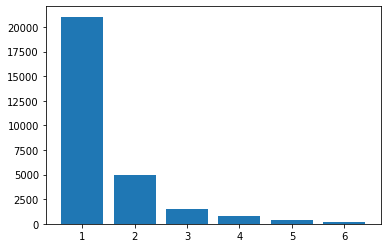

In [ ]:
plt.bar(num_categories.value_counts().keys(), num_categories.value_counts().values)

### Category distribution (how many times does each category appear)


In [ ]:
Categories = np.array([x for cat in X_train.categories for x in cat])

In [ ]:
unique, counts = np.unique(Categories, return_counts=True)

<BarContainer object of 43 artists>

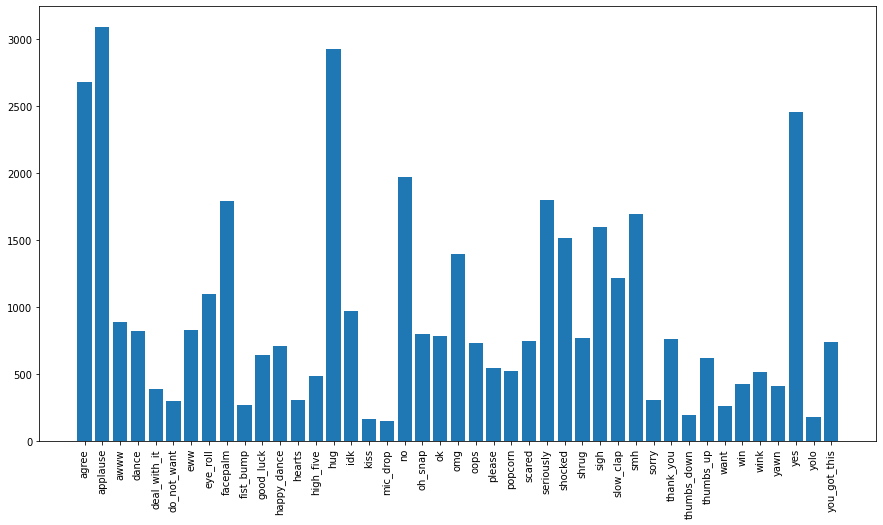

In [ ]:
plt.figure(figsize=(15, 8))
plt.xticks(rotation=90)
plt.bar(unique, counts)

### 10 most common pairs of co-occurring categories

In [ ]:
X_train[X_train.categories.apply(lambda x: len(x)) > 1].astype('str').categories.value_counts()[:10]

['slow_clap', 'applause']                   871
['agree', 'yes']                            815
['good_luck', 'you_got_this']               357
['shocked', 'omg']                          313
['oh_snap', 'shocked', 'omg']               247
['dance', 'happy_dance']                    242
['smh', 'seriously', 'facepalm', 'sigh']    218
['shrug', 'idk']                            211
['smh', 'facepalm', 'sigh']                 201
['hug', 'you_got_this']                     197
Name: categories, dtype: int64

### Text length

In [ ]:
train['length'] = train.text.apply(lambda x: len(x.split(' ')))

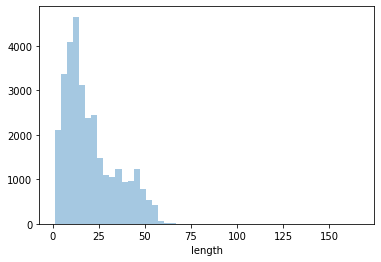

In [ ]:
sns.distplot(train.length, kde=False)

## Part 2: Prediction

### Majority Prediction (Baseline!)

In [ ]:
X_train.categories.astype('str').value_counts()[:6]

['hug']                      2679
['applause']                 1914
['no']                       1672
['agree']                    1611
['yes']                       927
['slow_clap', 'applause']     871
Name: categories, dtype: int64

In [ ]:
major_categories = ['hug', 'applause', 'no', 'yes', 'agree', 'slow_clap']

In [ ]:
test["categories"] = [major_categories] *len(test)

In [ ]:
test = test[['idx', 'categories', 'reply', 'text']]

In [ ]:
test.to_json('dev.json', orient='records', lines=True)

### Naive Bayes


### Only consider first GIF category in each sample (for simplification)


In [ ]:
# The following is done for simplification
train_y = [categories[0] for categories in X_train['categories'].to_list()] # probably not a good idea!
eval_y = [categories[0]  for categories in X_eval['categories'].to_list()]

### Compute sklearn TF-IDF vectorizer (TfidfVectorizer), default settings


In [ ]:
vectorizer = TfidfVectorizer() # using default parameters
vectorizer.fit(X_train['text'])
train_X = vectorizer.transform(X_train['text'])
test_X = vectorizer.transform(X_eval['text'])

train_X.shape, test_X.shape

((28800, 33132), (3200, 33132))

### Use sklearn Multinomial Naive Bayes classifier (MultinomialNB), default settings


In [ ]:
%%time
model = MultinomialNB()
model.fit(train_X.toarray(),train_y)
pred_y = model.predict(test_X.toarray())

CPU times: user 12.1 s, sys: 5.01 s, total: 17.1 s
Wall time: 12.3 s


In [ ]:
print(accuracy_score(eval_y, pred_y))
print(classification_report(eval_y, pred_y, digits=3, zero_division=0))

0.1953125
              precision    recall  f1-score   support

       agree      0.140     0.544     0.223       298
    applause      0.205     0.149     0.172       235
        awww      0.000     0.000     0.000        82
       dance      0.000     0.000     0.000        80
deal_with_it      0.000     0.000     0.000        37
 do_not_want      0.000     0.000     0.000        10
         eww      0.214     0.043     0.072        69
    eye_roll      0.275     0.114     0.161       123
    facepalm      0.000     0.000     0.000        38
   fist_bump      0.000     0.000     0.000        21
   good_luck      0.000     0.000     0.000        68
 happy_dance      0.000     0.000     0.000        56
      hearts      0.000     0.000     0.000        32
   high_five      0.000     0.000     0.000        30
         hug      0.195     0.968     0.325       310
         idk      0.000     0.000     0.000        26
        kiss      0.000     0.000     0.000        25
    mic_drop     

In [ ]:
print(model.classes_)

['agree' 'applause' 'awww' 'dance' 'deal_with_it' 'do_not_want' 'eww'
 'eye_roll' 'facepalm' 'fist_bump' 'good_luck' 'happy_dance' 'hearts'
 'high_five' 'hug' 'idk' 'kiss' 'mic_drop' 'no' 'oh_snap' 'ok' 'omg'
 'oops' 'please' 'popcorn' 'scared' 'seriously' 'shocked' 'shrug' 'sigh'
 'slow_clap' 'smh' 'sorry' 'thank_you' 'thumbs_down' 'thumbs_up' 'want'
 'win' 'wink' 'yawn' 'yes' 'yolo' 'you_got_this']


### For each sample, pick the 6 highest-probability categories

In [ ]:
categories_dict = {}
for i, cat in enumerate(model.classes_):
  categories_dict[i] = cat

In [ ]:
def num2cat(row):
  return [categories_dict[cat] for cat in row]
def pick_top_six(prob):
  best_6 = np.argsort(prob, axis=1)[:, -6:]
  results = []
  for row in best_6:
    results.append(num2cat(row))
  return results

In [ ]:
probabilities = model.predict_proba(test_X.toarray())
pick_top_six(probabilities)[:10]

[['awww', 'please', 'applause', 'no', 'agree', 'hug'],
 ['ok', 'slow_clap', 'no', 'applause', 'agree', 'hug'],
 ['seriously', 'slow_clap', 'no', 'applause', 'agree', 'hug'],
 ['seriously', 'slow_clap', 'no', 'applause', 'agree', 'hug'],
 ['seriously', 'slow_clap', 'no', 'applause', 'hug', 'agree'],
 ['seriously', 'slow_clap', 'no', 'applause', 'agree', 'hug'],
 ['yes', 'slow_clap', 'no', 'applause', 'hug', 'agree'],
 ['eye_roll', 'slow_clap', 'no', 'applause', 'agree', 'hug'],
 ['seriously', 'eye_roll', 'no', 'hug', 'applause', 'agree'],
 ['slow_clap', 'seriously', 'no', 'applause', 'hug', 'agree']]

### Check: is the performance on your test data similar to the performance on the evaluation data?

In [ ]:
test = pd.read_json('https://2020emotiongif.imfast.io/dev_unlabeled.json', lines=True)

In [ ]:
test_X = vectorizer.transform(test['text'])
test_X.shape

(4000, 33132)

In [ ]:
pred_y = model.predict(test_X.toarray())

In [ ]:
probabilities = model.predict_proba(test_X.toarray())

In [ ]:
pick_top_six(probabilities)[:10]

[['no', 'agree', 'dance', 'good_luck', 'applause', 'please'],
 ['seriously', 'slow_clap', 'no', 'applause', 'hug', 'agree'],
 ['seriously', 'slow_clap', 'no', 'applause', 'agree', 'hug'],
 ['slow_clap', 'smh', 'no', 'hug', 'applause', 'agree'],
 ['smh', 'eye_roll', 'no', 'applause', 'agree', 'hug'],
 ['slow_clap', 'seriously', 'hug', 'applause', 'no', 'agree'],
 ['yes', 'thank_you', 'no', 'applause', 'agree', 'hug'],
 ['hug', 'seriously', 'eye_roll', 'slow_clap', 'agree', 'applause'],
 ['no', 'agree', 'dance', 'good_luck', 'applause', 'please'],
 ['eye_roll', 'slow_clap', 'no', 'applause', 'agree', 'hug']]

In [ ]:
test["categories"] = pick_top_six(probabilities)
test = test[['idx', 'categories', 'reply', 'text']]

In [ ]:
test.to_json('dev_2.json', orient='records', lines=True)